# Visualize HDF5 outputs from GADGET-2 - Cluster simulation

In [2]:
import os
import h5py
import numpy as np

from scipy.interpolate import interpn

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize 
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from IPython.display import display

In [3]:
path = '/home/masterdesky/GADGET2/Simulations/cluster/'
out = './out/'

# Bold print for Jupyter Notebook
b1 = '\033[1m'
b0 = '\033[0m'

### Just some matplotlib and seaborn parameter tuning

In [4]:
axistitlesize = 20
axisticksize = 17
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

## Load HDF5 snapshots

In [5]:
snapshots = sorted([f for f in os.listdir(path) if 'snapshot' in f])

### PartType2

In [6]:
def density_scatter(x, y, sort=True, bins=[20,20]):
    """
    Scatter plot colored by 2d histogram
    """
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
    c = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])),
                data , np.vstack([x,y]).T,
                method='splinef2d', bounds_error=False)

    # To be sure to plot all data
    c[np.where(np.isnan(c))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = c.argsort()
        x, y, c = x[idx], y[idx], c[idx]

    return np.vstack([x,y]).T, c

In [7]:
sf = h5py.File(path + snapshots[-1], 'r')

In [8]:
xyz = np.array(list(sf['PartType2']['Coordinates']))

In [9]:
x = xyz[:, 0]
y = xyz[:, 1]
z = xyz[:, 2]
data_1, c_1 = density_scatter(x, y, sort=True, bins=[50,50]) # XY
data_2, c_2 = density_scatter(x, z, sort=True, bins=[50,50]) # XZ
data_3, c_3 = density_scatter(y, z, sort=True, bins=[50,50]) # YZ

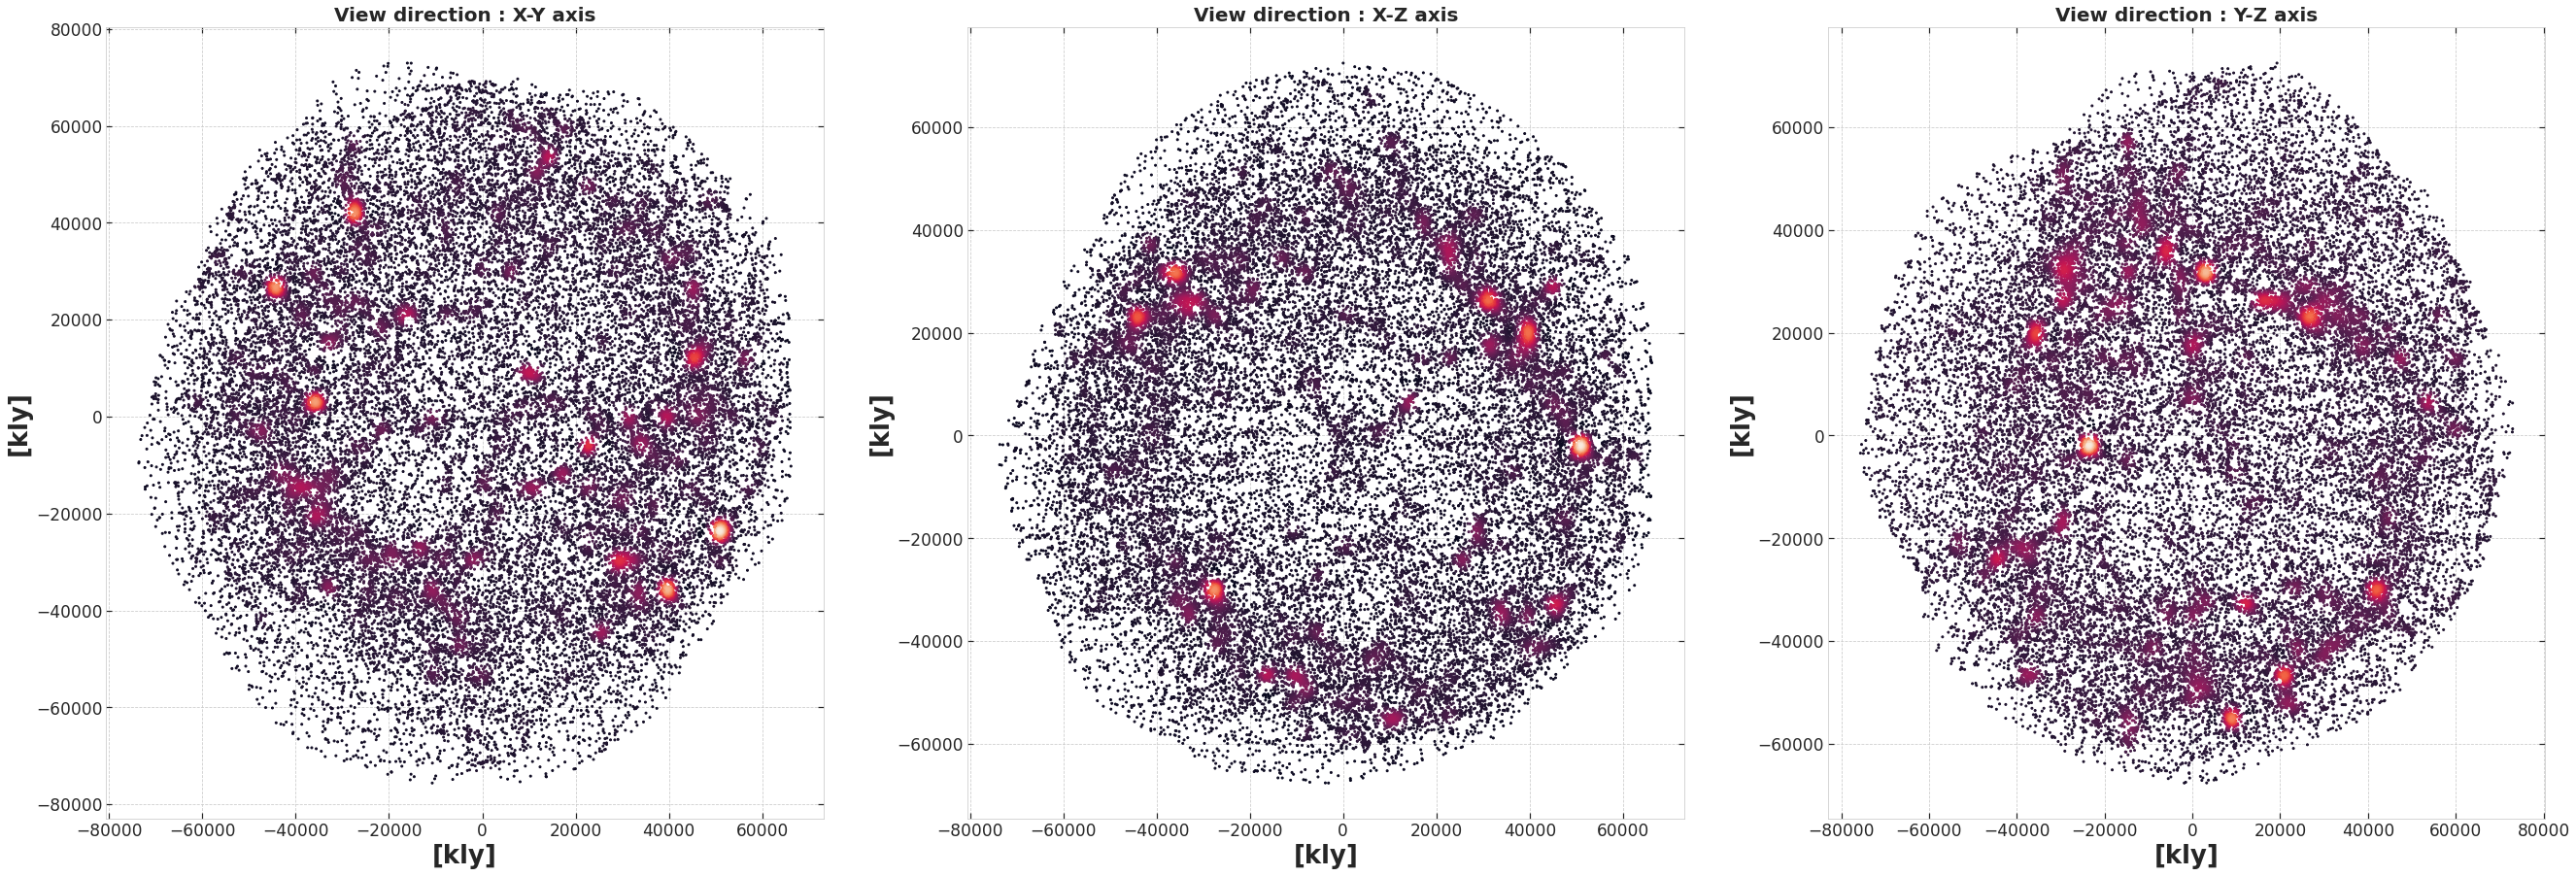

In [10]:
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*15, nrows*15))

sc = 2
# XY
ax = axes[0]
ax.scatter(data_1[:,0], data_1[:,1], c=c_1, s=sc**2)

# XZ
ax = axes[1]
ax.scatter(data_2[:,0], data_2[:,1], c=c_2, s=sc**2)

# YZ
ax = axes[2]
ax.scatter(data_3[:,0], data_3[:,1], c=c_3, s=sc**2)

view = [('X','Y'), ('X','Z'), ('Y','Z')]
for i, ax in enumerate(axes):
    ax.set_title('View direction : {0}-{1} axis'.format(view[i][0], view[i][1]),
                 fontsize=axistitlesize, fontweight='bold')
    ax.set_xlabel('[kly]', fontsize=axislabelsize, fontweight='bold')
    ax.set_ylabel('[kly]', fontsize=axislabelsize, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.show()

### 3D plot

In [11]:
from scipy import stats
from mayavi import mlab

In [12]:
mu, sigma = 0, 0.1 

xyz_kde = np.vstack([x,y,z])
kde = stats.gaussian_kde(xyz_kde)
density = kde(xyz_kde)

In [15]:
# Plot scatter with mayavi
figure = mlab.figure('DensityPlot')
pts = mlab.points3d(x, y, z, density, scale_mode='none', scale_factor=1e03)
axes = mlab.axes()

axes.axes.font_factor = 0.9

mlab.xlabel('X [kly]')
mlab.ylabel('Y [kly]')
mlab.zlabel('Z [kly]')

mlab.show()

## Animate HDF5 snapshots

In [16]:
class AnimatedCollision(object):
    """
    An animated scatter plot using matplotlib.animations.FuncAnimation.
    Based on : https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot
    """
    def __init__(self, snapshots, fps):
        self.snapshots = snapshots
        self.n_snapshots = len(snapshots)
        self.fps = fps

        self.nrows = 1
        self.ncols = 3        
        self.fig, self.axes = plt.subplots(self.nrows, self.ncols, figsize=(self.ncols*12, self.nrows*12))
        self.sc = 2
        # Setup `matplotlib`'s FuncAnimation
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=1000/self.fps, frames=self.n_snapshots,
                                           init_func=self.setup_plot, blit=True)
        # Set up formatting for the movie files
        self.Writer = animation.writers['ffmpeg']
        self.writer = self.Writer(fps=self.fps, metadata=dict(artist='BalageP'), bitrate=24000)

    def setup_plot(self):
        """
        Initial drawing of the scatter plot.
        """
        data_1, data_2, data_3, c_1, c_2, c_3 = next(self.data_stream(0))
        self.scat_0 = self.axes[0].scatter([], [], c=[], s=self.sc**2)
        self.scat_1 = self.axes[1].scatter([], [], c=[], s=self.sc**2)
        self.scat_2 = self.axes[2].scatter([], [], c=[], s=self.sc**2)
        
        # Set limits of axes
        self.axes[0].set_xlim(data_1[:,0].min(), data_1[:,0].max()) # X : -100, +100
        self.axes[0].set_ylim(data_1[:,1].min(), data_1[:,1].max()) # Y : -50, +50
        self.axes[1].set_xlim(data_2[:,0].min(), data_2[:,0].max()) # X : -100, +100
        self.axes[1].set_ylim(data_2[:,1].min(), data_2[:,1].max()) # Z : -100, +100
        self.axes[2].set_xlim(data_3[:,0].min(), data_3[:,0].max()) # Y : -50, +50
        self.axes[2].set_ylim(data_3[:,1].min(), data_3[:,1].max()) # Z : -100, +100

        # Set axes ticks and labels
        view = [('X','Y'), ('X','Z'), ('Y','Z')]
        for k, ax in enumerate(self.axes):
            ax.set_title('View direction : {0}-{1} axis'.format(view[k][0], view[k][1]),
                         fontsize=axistitlesize, fontweight='bold')
            ax.set_xlabel('[kly]', fontsize=axislabelsize, fontweight='bold')
            ax.set_ylabel('[kly]', fontsize=axislabelsize, fontweight='bold')
            ax.tick_params(axis='both', which='major', labelsize=axisticksize)
        
        # For FuncAnimation's sake, we need to return the artist we'll be using.
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat_0, self.scat_1, self.scat_2,

    def density_scatter(self, x, y, sort=True, bins=[20,20]):
        """
        Scatter plot colored by 2d histogram
        """
        data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
        c = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])),
                    data , np.vstack([x,y]).T,
                    method='splinef2d', bounds_error=False)

        # To be sure to plot all data
        c[np.where(np.isnan(c))] = 0.0

        # Sort the points by density, so that the densest points are plotted last
        if sort :
            idx = c.argsort()
            x, y, c = x[idx], y[idx], c[idx]

        return np.vstack([x,y]).T, c
    
    def data_stream(self, i):
        """
        Load states of the galaxies from the HDF5 files on the run to save memory.
        """
        while True:
            sf = h5py.File(path + self.snapshots[i], 'r')
            xyz = np.array(list(sf['PartType2']['Coordinates']))
            x = xyz[:, 0]
            y = xyz[:, 1]
            z = xyz[:, 2]
            data_1, c_1 = self.density_scatter(x, y, sort=True, bins=[50,50]) # XY
            data_2, c_2 = self.density_scatter(x, z, sort=True, bins=[50,50]) # XZ
            data_3, c_3 = self.density_scatter(y, z, sort=True, bins=[50,50]) # YZ
            yield data_1, data_2, data_3, c_1, c_2, c_3

    def update(self, i):
        """
        Update the scatter plot.
        """
        data_1, data_2, data_3, c_1, c_2, c_3 = next(self.data_stream(i))

        # Set data
        self.scat_0.set_offsets(data_1)
        self.scat_1.set_offsets(data_2)
        self.scat_2.set_offsets(data_3)
        
        # Set colors for data
        self.scat_0.set_array(c_1)
        self.scat_1.set_array(c_2)
        self.scat_2.set_array(c_3)

        # We need to return the updated artist for FuncAnimation to draw.
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat_0, self.scat_1, self.scat_2,

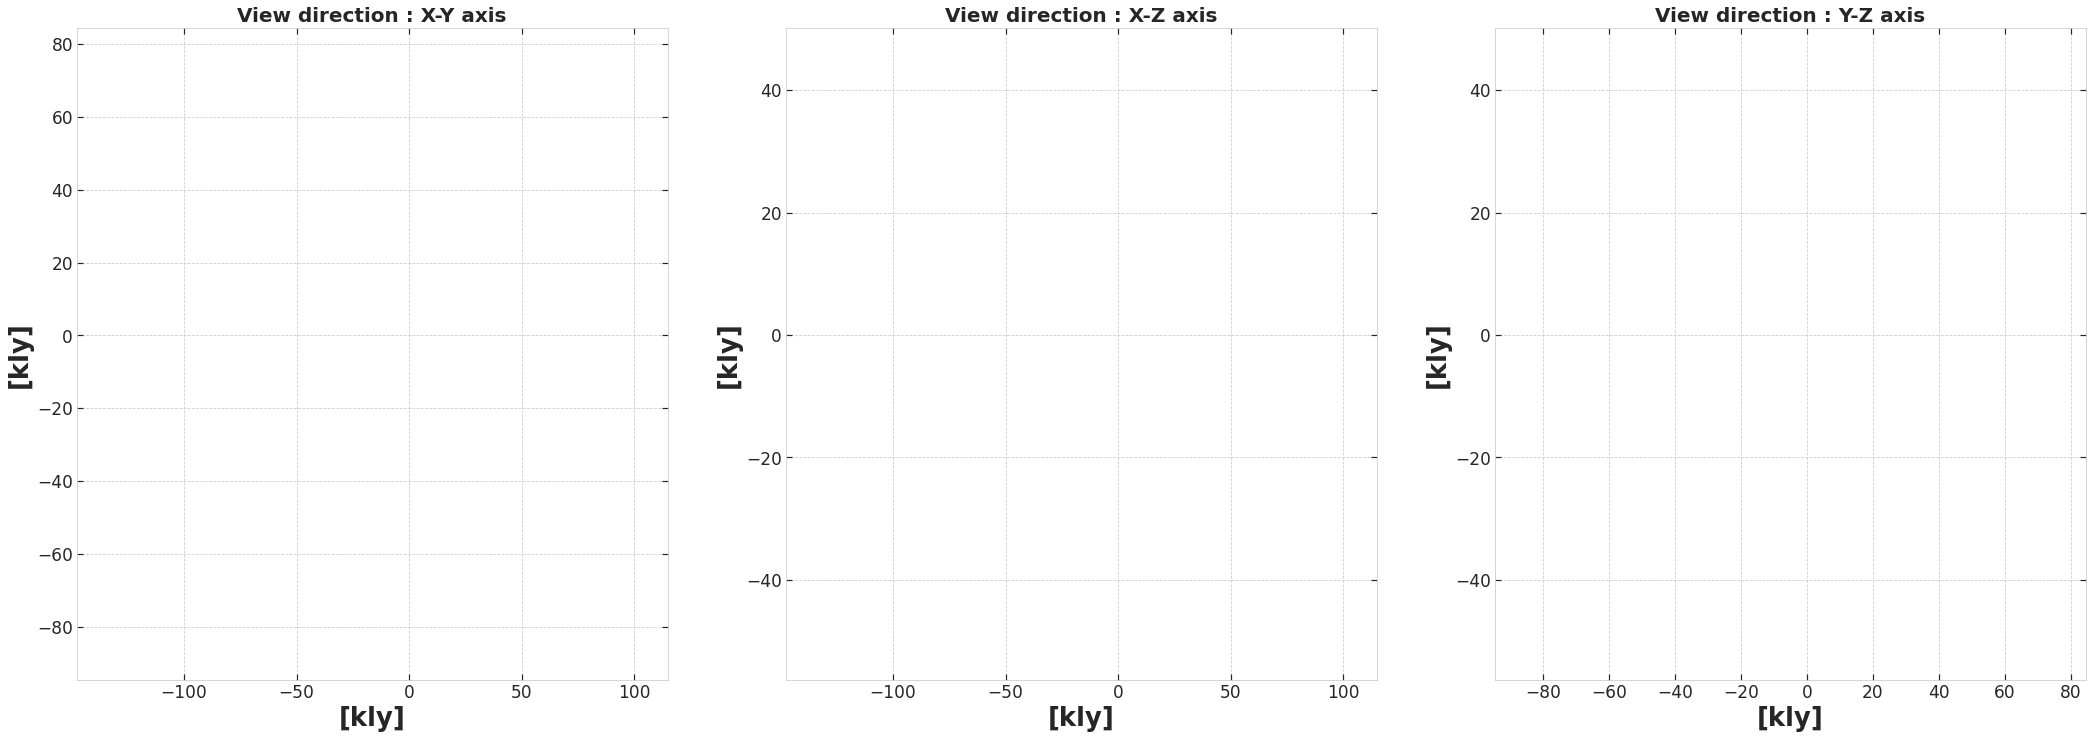

In [17]:
a = AnimatedCollision(snapshots, fps=60)

In [ ]:
a.ani.save('galaxy_density_60fps.mp4', writer=a.writer)